In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision
# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

from util   import *
from basics import *
from simulate_data import *
from estimators    import *
from config import *
from scipy.special import *
configure_pylab()   

In [2]:
# Shadow all pylab functions and numpy with the Jax versions
# Keep numpy around as np0 for easier RNG, array assignments
import jax
import jax.numpy as np
import numpy.random as npr
from jax               import jit, grad, vmap
from jax.config        import config
from jax.scipy.special import logsumexp
from jax.numpy         import *
from jax import jacfwd, jacrev
from jax import lax
from jax.numpy.fft import *
from jax.numpy.linalg import *
fori = lax.fori_loop
def hess(f,inparam):
    return jacfwd(jacrev(f,inparam),inparam)
def hvp(f, x, v):
    return grad(lambda x: vdot(grad(f)(x), v))(x)
import numpy as np0

# redefine these with Jax env so it can be traced
def conv(x,K):
    return real(ifft2(fft2(x.reshape(L,L))*K))
def slog(x,minrate = 1e-10):
    return log(maximum(minrate,x))
def sexp(x,bound = 10):
    return exp(clip(x,-bound,bound))
from numpy.linalg import cholesky as chol
def logdetpsd(Σ):
    return 2*sum(slog(diag(chol(Σ))))
def vec(X):
    return X.ravel()

## Simulate grid cell data 

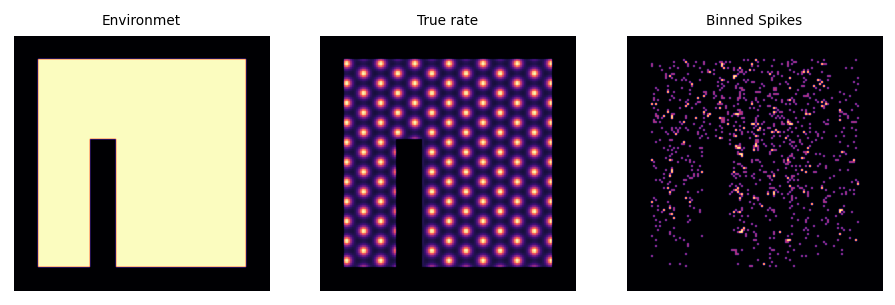

In [484]:
L = 128 # Grid size
P = L/15  # Grid spacing
α = 0.5  # Grid "sharpness"
μ = 2500/L**2 # Mean firing rate (spikes per sample)
mask,λ0,λ0_bg,N,K = simulate_data(L,P,α,μ)
subplot(131); showim(mask,'Environmet')
subplot(132); showim(λ0,'True rate')
subplot(133); showim(K,'Binned Spikes');

# Heuristic LGCP

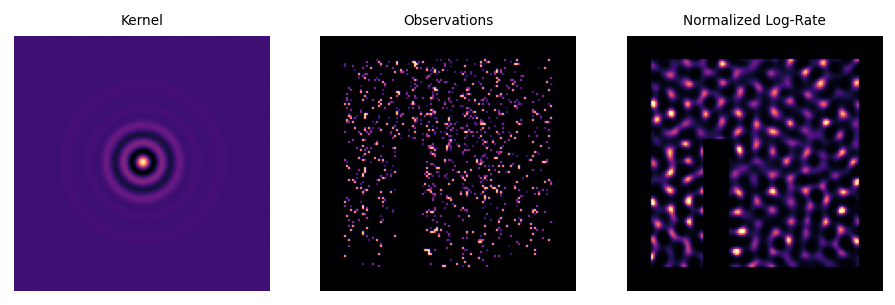

In [485]:
fgσ  = P/pi
bgσ  = fgσ*5

# Bessel function
coords = zgrid(L)
kernR  = j0(fftshift(abs(coords*2*pi/P)))
window = hanning(L)
window = outer(window,window)
kernR  = kernR*fftshift(window)
fftkr  = fftshift(real(ifft2(kernR)))

# Restrict kernel to local neighborhood and normalize
k3     = jn_zeros(0,5)[-1]
fwin   = abs(coords)<P*k3/(2*pi)
kern0  = kernR*fftshift(fwin)
kern0  = blur(kern0,P/pi)
kern0  = kern0/np.max(kern0)

# Prepare data
lλb  = slog(kdeλ(N,K,bgσ))     # Log background (initial estimate)
lλf  = slog(kdeλ(N,K,fgσ))-lλb # Log foreground (initial estimate)
n    = N.ravel()               # Number of visits per bin
y    = nan_to_num(K/N).ravel() # Lumped pseudo-observerations
lλb  = lλb.ravel()             # Background offsets

# Heuristic kernel
kern = kern0*zerolag(radial_acorr(lλf,mask))
kern = repair_small_eigenvalues(kern,1e-5)
knft = np0.array(real(fft2(kern)))
knft[0,0] += 1e6
kift = 1.0/knft

# Prepare gradient and hessian operators
M  = cop(knft)
Ki = cop(kift)
J  = lambda w: Ki@w + n*(exp(w+lλb)-y)
H  = lambda w: Ki   + diagop(n*exp(w+lλb))

# Fit model and unpack result
w2  = newton_raphson(lλf,J,H,M)
subplot(131); showkn(kern,'Kernel');
subplot(132); showim(np0.array(y)   ,'Observations');
subplot(133); showim(exp(w2)  ,'Normalized Log-Rate',mask=mask);

# Diagonal heuristic

$$
1/v = nλ
$$

```
F'(FΛF' + FD[p]F')¯¹F
```

In [486]:
Kf = knft
thr = np.max(array(sorted(abs(Kf).ravel()))[:-1])/5

keep2d   = (abs(Kf))>thr
keep2d   = keep2d | keep2d.T
keep     = where(keep2d.ravel())[0]
keep1d   = any(keep2d,axis=0)
elements = fft(eye(L),norm='ortho')[:,keep1d]
R1d      = sum(keep1d)
keepcut  = where(keep2d[:,keep1d][keep1d,:].ravel())[0]

R     = len(keep)
Rlt   = (R*(R+1))//2
T = L*L
down  = eye(T)[keep]
def reverse(A):
    return roll(roll(A[::-1,:],1,axis=0)[:,::-1],1,axis=1)
hperm = int32(down@reverse((down.T@(arange(R))).reshape(L,L)).ravel())
def hcv(kh,xh):
    kh/= 2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)*xh+(kh-kr)*xr
def hcm(kh,xh):
    kh/= 2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)[:,None]*xh+(kh-kr)[:,None]*xr
def Ftv(v):  # Collapse vector DOWN
    return fhtv(v)[keep]
def Fv(v):
    return fhtv(zeros(T).at[keep].set(v))
def RI(x):
    return real(x)+imag(x)
def fhtv(v):
    return RI(fft2(v.reshape(L,L),norm='ortho').ravel())
def fhtA(x):
    return RI(fft2(x.reshape(x.shape[0],L,L),norm='ortho').reshape(x.shape[0],T))
def FtA(A):  # Collapse matrix DOWN
    return fhtA(A.T).T[keep,:]
def FA(A):  
    return fhtA(zeros((T,A.shape[-1])).at[keep,:].set(A).T).T
def dv(Q):
    return sum(FA(tril(Q))**2,1)
def chol(x):
    return jax.scipy.linalg.cholesky(x,lower=True)
def ltinv(ch):
    q,info = scipy.linalg.lapack.dtrtri(ch,lower=True)
    if info!=0: raise ValueError('lapack.dtrtri: '+(
            'argument %d invalid'%-info if info<0 
            else 'diagonal element %d is 0'%info))
    return q
# Fourier convolution
def cv(K,v):
    return real(ifft2(fft2(v.reshape(L,L),norm='ortho')*K,norm='ortho')).ravel()
def cm(K,M):
    return real(ifft2(
        K[:,:,None]*fft2(M.reshape(L,L,M.shape[-1]),axes=(0,1)),
        axes=(0,1))).reshape(T,M.shape[-1])

In [487]:
Λf = 1.0/Kf
K0 = real(ifft2(Kf))
Kh = RI(Kf).ravel()[keep]
Λh = RI(Λf).ravel()[keep]
sK = sum(log(Kf[keep2d]))
nK = sum(keep2d)

Λr = hcm(Λh,eye(R))

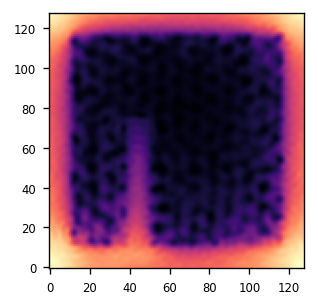

In [488]:
def er(a,b): print(max(abs(a-b)))

nλ = n*exp(w2 + lλb)

def fast_inverse_diagonal(nλ):
    X  = RI(contract('ij,ik,jl->klij',sqrt(nλ).reshape(L,L),elements,elements))
    X  = X.reshape(R1d*R1d,L*L)[keepcut]
    A  = ltinv(chol(Λr + X@X.T))
    A  = zeros((R,T)).at[:,keep].set(A).reshape(R,L,L)
    DF = RI(fft2(A,norm='ortho').reshape(R,T))
    v2 = sum(DF**2,0)
    return v2

p = fast_inverse_diagonal(nλ)
subplot(131)
imshow(p.reshape(L,L))

In [ ]:
μ0 = lλb.ravel()
μ  = lλf.ravel()

# Prepare gradient and hessian operators
M  = cop(knft)
Ki = cop(kift)
J  = lambda μ: Ki@μ + n*(exp(μ+μ0)-y)
H  = lambda μ: Ki   + diagop(n*exp(μ+μ0))

Δ = -minres(H(μ),J(μ),tol=1e-7,M=M)[0]
print(max(abs(Δ)))
μ += Δ

nλ = n*exp(μ + μ0)
v  = fast_inverse_diagonal(nλ)
    
for i in range(10):
    J  = lambda μ: Ki@μ + n*(exp(μ+μ0+v/2)-y)
    H  = lambda μ: Ki   + diagop(n*exp(μ+μ0+v/2))
    for j in range(1):
        Δ = -minres(H(μ),J(μ),tol=1e-6,M=M)[0]
        print('μ',j,max(abs(Δ)))
        μ += Δ
        if max(abs(Δ))<1e-6: break
    for j in range(1):
        nλ = n*exp(μ + μ0 + v/2)
        v2  = fast_inverse_diagonal(nλ)
        Δ = v2-v
        v += Δ
        print('v',j,max(abs(Δ)))
        if max(abs(Δ))<1e-6: break


23.28418894790503
μ 0 1.0825602838086723
μ 1 1.0191885342296299
μ 2 0.6610541184396459
μ 3 0.07075108924389263
μ 4 0.02014353817573026
μ 5 0.004515409708376068
μ 6 0.0011282324666360682
μ 7 0.00037044570303730416
μ 8 3.553483265647961e-05
μ 9 1.1268759416676312e-05
μ 10 2.836489725102252e-06
μ 11 4.482041810738731e-07
v 0 0.948101286159647
v 1 0.3442639107343606
v 2 0.12869616086026825
v 3 0.04893661530727633
v 4 0.0189702170773014
v 5 0.007805360049876198
v 6 0.0032786061921159515
v 7 0.0014047192306847478
v 8 0.0006131357674918902
v 9 0.0002722226950964135
μ 0 0.1933335659602633
μ 1 0.07927840370866927
μ 2 0.01535923753494252
μ 3 0.004612697976630288
μ 4 0.0008724793172098083
μ 5 0.00015998145760550713
μ 6 4.2932372652712035e-05
μ 7 8.844410793888064e-06
μ 8 2.6675933138047095e-06
μ 9 5.968380636853846e-07
v 0 0.15063436993657708
v 1 0.05161623298174023
v 2 0.018710413747459187
v 3 0.006874497967449322
v 4 0.0025569751290452913
v 5 0.000961744713340984
v 6 0.0003653813954134222
v 7 0

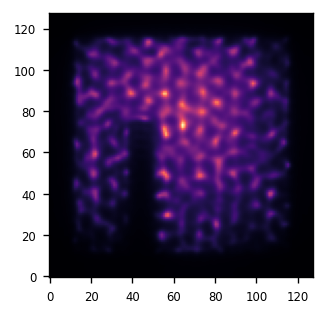

In [493]:
imshow(1/p.reshape(L,L))

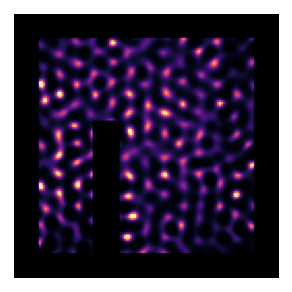

In [494]:
λ = exp(μ + μ0 + v/2)
showim(λ.reshape(L,L),mask=mask)

In [495]:

for j in range(10):
    nλ = n*exp(μ + μ0 + v/2)
    v2  = fast_inverse_diagonal(nλ)
    print('v',j,max(abs(v2-v)))
    v = (v2-v)*0.05

v 0 4.594053484960014
v 1 4.5940534849604155
v 2 4.5940534849603925
v 3 4.594053484960397
v 4 4.594053484960397
v 5 4.594053484960397
v 6 4.594053484960397
v 7 4.594053484960397
v 8 4.594053484960397
v 9 4.594053484960397
